# 1

In [1]:
import os

# gets rid of irritating warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from datasets import load_dataset

dataset = load_dataset("PolyAI/banking77", trust_remote_code=True)

train_data = dataset['train'].to_pandas()
test_data = dataset['test'].to_pandas()

In [4]:
train_data.head()

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11


In [5]:
test_data.head()

,text,label
0,How do I locate my card?,11
1,"I still have not received my new card, I order...",11
2,I ordered a card but it has not arrived. Help ...,11
3,Is there a way to know when my card will arrive?,11
4,My card has not arrived yet.,11


In [6]:
train_data.dtypes

text     object
label     int64
dtype: object

In [7]:
test_data.dtypes

text     object
label     int64
dtype: object

In [8]:
print(f"Shape of train dataset {train_data.shape}")
print(f"Shape of test dataset {test_data.shape}")

Shape of train dataset (10003, 2)
Shape of test dataset (3080, 2)


In [9]:
train_tabel_counts = train_data["label"].value_counts().sort_values(ascending=False)
test_tabel_counts = test_data["label"].value_counts().sort_values(ascending=False)

<Axes: xlabel='label'>

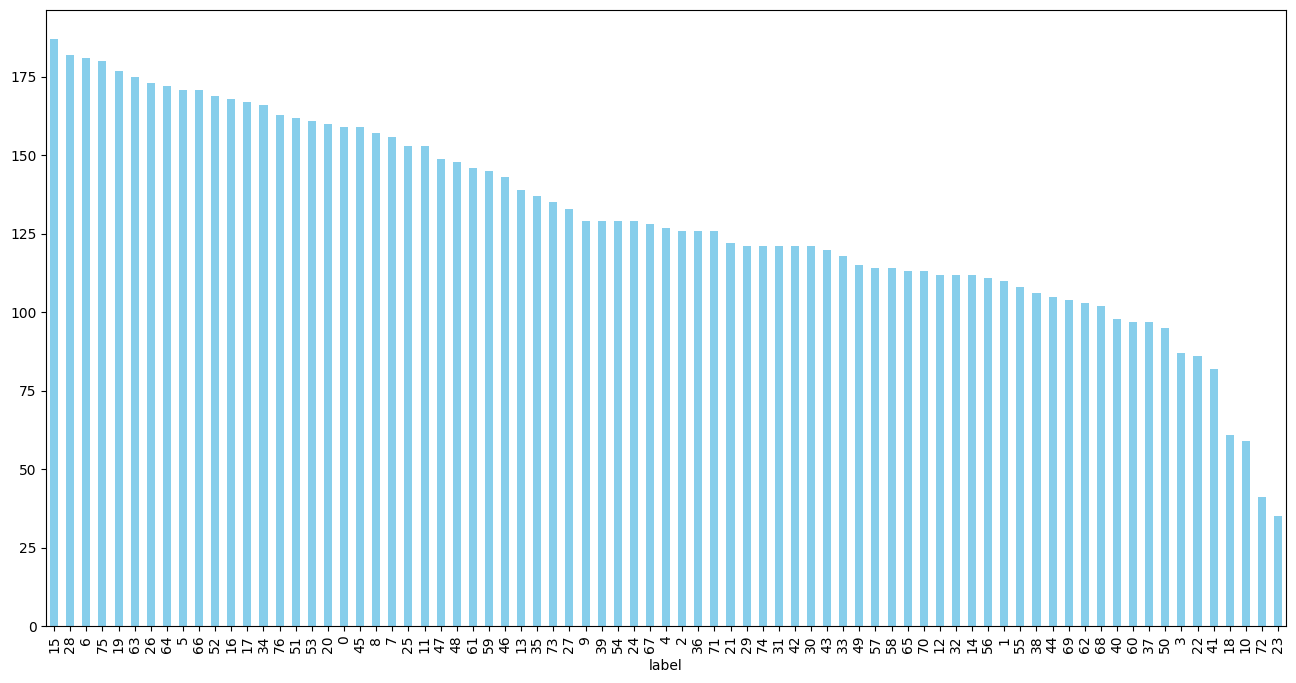

In [10]:
plt.figure(figsize=(16, 8))
train_tabel_counts.plot(kind='bar', color='skyblue')

<Axes: xlabel='label'>

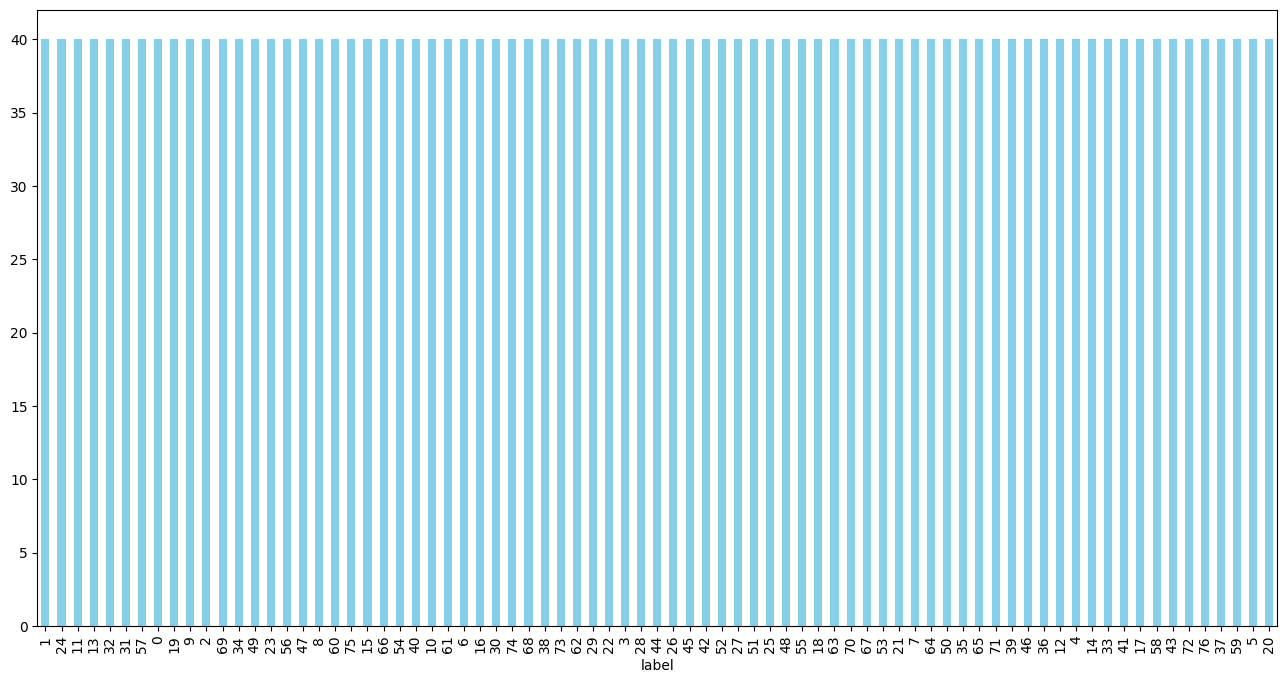

In [11]:
plt.figure(figsize=(16, 8))
test_tabel_counts.plot(kind='bar', color='skyblue')

In [12]:
train_data["text"].str.len()

0        30
1        60
2        58
3        59
4        54
         ..
9998     38
9999     34
10000    35
10001    30
10002    32
Name: text, Length: 10003, dtype: int64

<Axes: title={'center': 'Train data texts len'}, ylabel='Frequency'>

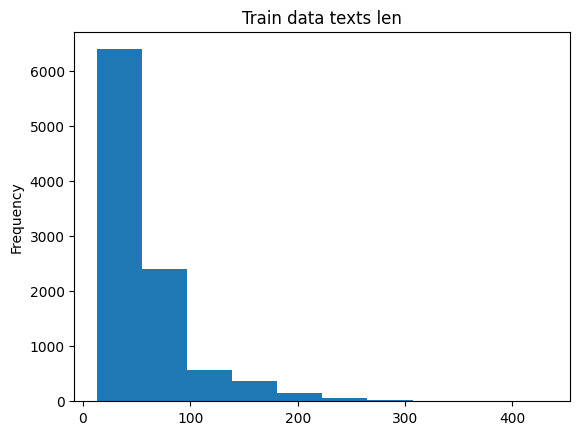

In [13]:
train_data["text"].str.len().plot.hist(title="Train data texts len")

<Axes: title={'center': 'Test data texts len'}, ylabel='Frequency'>

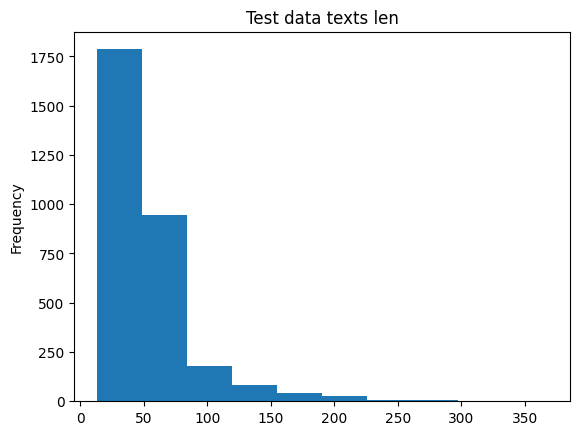

In [14]:
test_data["text"].str.len().plot.hist(title="Test data texts len")

# 2

In [15]:
import joblib
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict


def get_initial_model_data(texts: np.ndarray, labels: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    log_reg = LogisticRegression(class_weight="balanced")

    embeddings = model.encode(texts)

    pred_probs = cross_val_predict(log_reg, embeddings, y=labels, method="predict_proba")

    return embeddings, pred_probs


In [16]:
texts = train_data["text"].values
labels = train_data["label"].values

embeddings, pred_probs = get_initial_model_data(texts, labels)

In [17]:
from cleanlab import Datalab

data_dict = {"texts": texts, "labels": labels}
lab = Datalab(data_dict, label_name="labels", task="classification")
lab.find_issues(pred_probs=pred_probs, features=embeddings)
lab.report()

Finding null issues ...
Finding label issues ...
Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 648 issues found in the dataset.
Dataset Information: num_examples: 10003, num_classes: 77

Here is a summary of various issues found in your data:

    issue_type  num_issues
near_duplicate         350
         label         166
       outlier         131
       non_iid           1

Learn about each issue: https://docs.cleanlab.ai/stable/cleanlab/datalab/guide/issue_type_description.html
See which examples in your dataset exhibit each issue via: `datalab.get_issues(<ISSUE_NAME>)`

Data indices corresponding to top examples of each issue are shown below.


------------------ near_duplicate issues -------------------

About this issue:
	A (near) duplicate issue refers to two or more examples in
    a dataset that are extremely similar to each other, relative
  

In [18]:
duplicate_issues = lab.get_issues("near_duplicate")
duplicate_issues = duplicate_issues[duplicate_issues["is_near_duplicate_issue"]]
duplicate_issues = duplicate_issues.sort_values(by="near_duplicate_score")

In [19]:
for idx, row in duplicate_issues.head(5).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Text: I put the wrong pin too many times and now it is blocked. Can you help me unblock it?
	Duplicates: ['\nI put the wrong pin too many times and now it is blocked. Can you help me unblock it?']

Text: I can't seem to be able to use my card
	Duplicates: ["\nI can't seem to be able to use my card\n\n\n"]

Text: Do I need to go to a physical bank to change my PIN?
	Duplicates: ['\nDo I need to go to a physical bank to change my PIN?']

Text: 
I can't seem to be able to use my card



	Duplicates: ["I can't seem to be able to use my card"]

Text: Why do you keep declining my payment? I tried several times already with this card and it is just not working.
	Duplicates: ['Why do you keep declining my payment?I tried several times already with this card and it is just not working.'
 'Why do you keep declining my payment?I tried several times with this card and it is just not working.']



In [20]:
for idx, row in duplicate_issues.tail(5).iterrows():
    text = texts[idx]
    neighbors = texts[row["near_duplicate_sets"][:3]]
    print(f"Text: {text}")
    print(f"\tDuplicates: {neighbors}")
    print()

Text: Is there a limit to using a disposable virtual card?
	Duplicates: ['Is there a limit to a disposable virtual card?']

Text: Is there a limit to a disposable virtual card?
	Duplicates: ['Is there a limit to using a disposable virtual card?']

Text: Can I top up any amount?
	Duplicates: ['Can I top-up any amount?']

Text: Can I top-up any amount?
	Duplicates: ['Can I top up any amount?']

Text: How long will a transfer from the US take?
	Duplicates: ['How long does a transfer from the US take?']



In [21]:
train_data["text_cleaned"] = train_data["text"].str.lower().str.replace('\n', ' ').str.strip()
df_deduplicated = train_data.drop_duplicates(subset="text_cleaned")
df_deduplicated = df_deduplicated.drop(columns="text_cleaned")
# df_deduplicated = df_deduplicated.reset_index(drop=True)
df_deduplicated

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


In [22]:
train_data = df_deduplicated.copy()
train_data.shape

(9999, 2)

In [23]:
label_issues = lab.get_issues("label")
label_issues = label_issues[label_issues["is_label_issue"]]
label_issues = label_issues.sort_values(by="label_score")

top_label_issues_y_true = label_issues.head(10)["given_label"]
top_label_issues_y_pred = label_issues.head(10)["predicted_label"]
top_label_issues_idxs = label_issues.head(10).index
top_label_issues_texts = texts[top_label_issues_idxs]

print("Top 10 label issues")
for text, y_true, y_pred in zip(top_label_issues_texts, top_label_issues_y_true, top_label_issues_y_pred):
    print(f"y_true {y_true}, y_pred {y_pred}, text: {text}")
    print()

Top 10 label issues
y_true 47, y_pred 62, text: i put money on my card and i dont see it on the balance

y_true 29, y_pred 40, text: i am not a premium customer but i want a virtual card, how do i get it

y_true 26, y_pred 14, text: Is my card actually working? It's the first time I tried using it

y_true 65, y_pred 62, text: How do I top up?

y_true 59, y_pred 25, text: My credit card transaction was declined for a loan payment.  Can you tell me why?

y_true 48, y_pred 5, text: I have not seen any changes in my account balance(s) after making a transfer.

y_true 41, y_pred 11, text: Can you tell me the status of my new card?

y_true 67, y_pred 5, text: I just did a transfer, but don't see the money in my account. What's up?

y_true 26, y_pred 49, text: my card was frozen due to putting in the wrong pin too much.  how many tries do i have

y_true 22, y_pred 41, text: How do I order a replacement for stolen card?



In [24]:
label_issues = label_issues[label_issues.index.isin(train_data.index)]

idxs = label_issues.index.tolist()
pred_labels = label_issues["predicted_label"]

train_data.loc[idxs, "label"] = pred_labels
train_data

,text,label
0,I am still waiting on my card?,11
1,What can I do if my card still hasn't arrived ...,11
2,I have been waiting over a week. Is the card s...,11
3,Can I track my card while it is in the process...,11
4,"How do I know if I will get my card, or if it ...",11
...,...,...
9998,You provide support in what countries?,24
9999,What countries are you supporting?,24
10000,What countries are getting support?,24
10001,Are cards available in the EU?,24


In [25]:
len(idxs)

166

I fixed labels but some labels are very similar to each other so I am unsure if every fix should take place. I am no expert here. In paper they found more wrong labels (590). They used Cosine Similarity and chacked rows with score higher than 0.85. I believe them that there are more labels to fix there.

In [26]:
outliers_issues = lab.get_issues("outlier")
outliers_issues = outliers_issues[outliers_issues["is_outlier_issue"]]
outliers_issues = outliers_issues.sort_values(by="outlier_score")
outliers_issues.shape

(131, 2)

In [27]:
print("Top 10 outliers:")
for idx, row in outliers_issues.head(10).iterrows():
    text = texts[idx]
    print(text)

Top 10 outliers:
WHAT IS THE ATMOSPHERE OF IT
what is the word?
What is this witdrawal
what is the matter?
WHAT IS THE SOLUTION OF THIS PROBLEM
I prefer Mastecard.
I have made 5 attempts to make a very standard survey, yet I can't get it to work. What is the problem? Is there an issue related to your system?
WHAT IS THE MAIN REASON OF THIS PROBLEM
WHAT IS THE REASON FOR THAT
why was i chargged


In [28]:
print("Top 10 (but from the end) outliers (but still outliers):")
for idx, row in outliers_issues.tail(10).iterrows():
    text = texts[idx]
    print(text)

Top 10 (but from the end) outliers (but still outliers):
can the delivery be specific to my needs?
How do I get refills to my card when I'm traveling?
Would reinstalling the app solve the problem?
If I top-up by using a trasfer are there charges that applied?
Do you take checks?
I forgot my code
Why are you asking so many questions about who I am
I tried activating my plug-in and it didn't piece of work
I made a deposit a couple of days back it's, as of yet, not gone in! It would be ideal if you assist me with this
passcode retrieval


Some outliers are meaningful in my opinion. I will not delete them

# 3

In [29]:
import torch
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

train_size = int(0.8 * len(train_data))

df_train, df_valid = train_test_split(train_data, train_size=train_size, random_state=0, stratify=train_data["label"])

datasets_dict = DatasetDict()
datasets_dict["train"] = Dataset.from_pandas(df_train, split="train")
datasets_dict["valid"] = Dataset.from_pandas(df_valid, split="valid")
datasets_dict["test"] = Dataset.from_pandas(test_data, split="test")

In [30]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")


def tokenize(examples: dict) -> dict:
    encoded_examples = tokenizer(examples["text"], padding=True, truncation=True)
    encoded_examples["label"] = torch.tensor(examples["label"])
    return encoded_examples


num_cores = joblib.cpu_count(only_physical_cores=True)
datasets_tokenized = datasets_dict.map(tokenize, batched=True)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

In [ ]:
import os
import random

from sklearn.metrics import f1_score
from torch.nn.functional import softmax
from transformers import AutoModelForSequenceClassification, EvalPrediction, Trainer, TrainingArguments


# set determinism settings
os.environ["PYTHONHASHSEED"] = str(0)
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

model = AutoModelForSequenceClassification.from_pretrained("distilbert/distilbert-base-uncased", num_labels=77)


def compute_metrics(eval_pred: EvalPrediction) -> dict:
    y_true = eval_pred.label_ids.ravel()
    logits = eval_pred.predictions
    y_pred = np.argmax(logits, axis=1)
    f1 = f1_score(y_true, y_pred, average="macro")
    return {"F1": f1}


training_args = TrainingArguments(
    output_dir="finetuned_model",
    # change num_train_epochs depending on your hardware
    # if lower, increase learning rate and decrease save_steps and eval_steps
    learning_rate=1e-5,
    num_train_epochs=10,
    eval_strategy="steps",
    save_steps=50,
    eval_steps=50,
    save_total_limit=1,
    load_best_model_at_end=True,
    seed=0,
    data_seed=0,
    fp16=True,  # comment this out if you have unsupported hardware
    dataloader_num_workers=1,  # comment out if necessary
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=datasets_tokenized["train"],
    eval_dataset=datasets_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)
trainer.train()

In [32]:
trainer.state.log_history[-2]

{'eval_loss': 0.2637939155101776,
 'eval_F1': 0.9293335941167903,
 'eval_runtime': 1.2721,
 'eval_samples_per_second': 1572.191,
 'eval_steps_per_second': 196.524,
 'epoch': 10.0,
 'step': 10000}

In [33]:
trainer.state.log_history[-1]

{'train_runtime': 740.8922,
 'train_samples_per_second': 107.964,
 'train_steps_per_second': 13.497,
 'total_flos': 1756931299369824.0,
 'train_loss': 0.8308601615905762,
 'epoch': 10.0,
 'step': 10000}

In [34]:
from sklearn.metrics import f1_score, matthews_corrcoef, precision_score, recall_score, roc_auc_score


pred_output = trainer.predict(datasets_tokenized["test"])
logits = pred_output.predictions
y_pred = np.argmax(logits, axis=1)
y_test = datasets_tokenized["test"]["label"]

print(f"Precision: {precision_score(y_test, y_pred, average='macro'):.2%}")
print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.2%}")
print(f"F1-score: {f1_score(y_test, y_pred, average='macro'):.2%}")
print(f"AUROC: {roc_auc_score(y_test, softmax(torch.from_numpy(pred_output.predictions)), multi_class='ovo'):.2%}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.2%}")

Precision: 91.82%
Recall: 91.49%
F1-score: 91.48%
AUROC: 99.86%
MCC: 91.39%


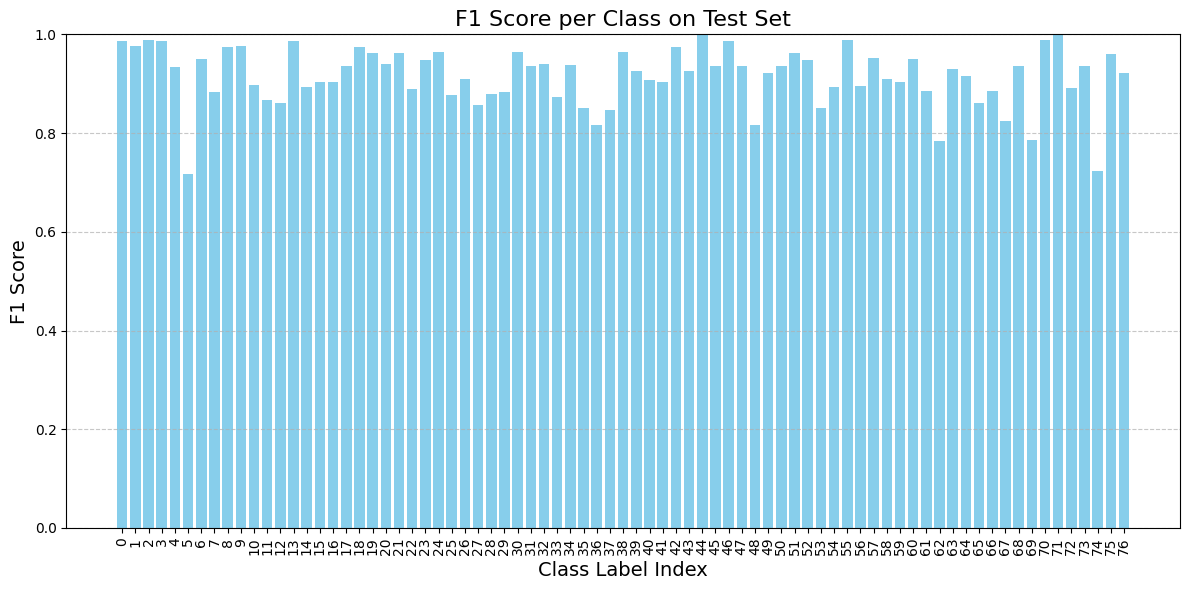

In [35]:
class_f1_scores = f1_score(y_test, y_pred, average=None)
class_labels = np.unique(y_test)

plt.figure(figsize=(12, 6))
bars = plt.bar(class_labels, class_f1_scores, color='skyblue')

plt.title("F1 Score per Class on Test Set", fontsize=16)
plt.xlabel("Class Label Index", fontsize=14)
plt.ylabel("F1 Score", fontsize=14)

plt.xticks(class_labels, fontsize=10, rotation=90)
plt.ylim(0, 1.0)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

My F1 score is 91.5%. In paper F1 is 92%. I am proud of myself :)\
Class 5 (balance_not_updated_after_bank_transfer) and 74 (why_verify_identity) have the worst F1 score equal 70%.

In [36]:
from giskard import Model as GiskardModel, Dataset as GiskardDataset, scan, testing
from transformers import pipeline

trained_model = trainer.model
trained_model.eval()
model_pipeline = pipeline(
    "text-classification",
    model=trained_model,
    tokenizer=tokenizer,
    device="cuda" if torch.cuda.is_available() else "cpu",
    return_all_scores=True
)


@torch.no_grad()
def prediction_function(df: pd.DataFrame) -> np.ndarray:
    pred_output = model_pipeline(df["text"].tolist())

    y_pred_proba = np.array([[cls["score"] for cls in sample] for sample in pred_output])
    return y_pred_proba


giskard_dataset = GiskardDataset(test_data, target="label")

giskard_model = GiskardModel(
    model=prediction_function,
    model_type="classification",
    classification_labels=[i for i in range(77)],
    feature_names=["text"],
)
scan_results = scan(giskard_model, giskard_dataset, verbose=False)
display(scan_results)

Device set to use cuda


2025-12-01 03:12:23,403 pid:121263 MainThread giskard.datasets.base INFO     Your 'pandas.DataFrame' is successfully wrapped by Giskard's 'Dataset' wrapper class.
2025-12-01 03:12:23,403 pid:121263 MainThread giskard.models.automodel INFO     Your 'prediction_function' is successfully wrapped by Giskard's 'PredictionFunctionModel' wrapper class.
2025-12-01 03:12:23,408 pid:121263 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-12-01 03:12:23,447 pid:121263 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (10, 2) executed in 0:00:00.041435
2025-12-01 03:12:23,451 pid:121263 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-12-01 03:12:23,456 pid:121263 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1, 2) executed in 0:00:00.007515
2025-12-01 03:12:23,459 pid:121263 MainThread giskard.dataset

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


2025-12-01 03:13:02,232 pid:121263 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1000, 2) executed in 0:00:01.912886
2025-12-01 03:13:02,232 pid:121263 MainThread giskard.scanner.logger INFO     TextPerturbationDetector: Testing `text` for perturbation `Add typos`	Fail rate: 0.284
2025-12-01 03:13:02,255 pid:121263 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-12-01 03:13:02,256 pid:121263 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1000, 2) executed in 0:00:00.003642
2025-12-01 03:13:02,259 pid:121263 MainThread giskard.datasets.base INFO     Casting dataframe columns from {'text': 'object'} to {'text': 'object'}
2025-12-01 03:13:04,172 pid:121263 MainThread giskard.utils.logging_utils INFO     Predicted dataset with shape (1000, 2) executed in 0:00:01.915169
2025-12-01 03:13:04,172 pid:121263 MainThread giskard.scanner.logger INFO     TextPerturba

<iframe id="scan-134914944422096" srcdoc="<!doctype html>
<html lang="en">

<head>
 <title>Giskard Scan Results</title>
 <base target="_blank">
 <meta charset="utf-8">
 
<style>pre code.hljs{display:block;overflow-x:auto;padding:1em}code.hljs{padding:3px 5px}
/*!
 Theme: GitHub Dark
 Description: Dark theme as seen on github.com
 Author: github.com
 Maintainer: @Hirse
 Updated: 2021-05-15

 Outdated base version: https://github.com/primer/github-syntax-dark
 Current colors taken from GitHub's CSS
*/.hljs{background:#0d1117;color:#c9d1d9}.hljs-doctag,.hljs-keyword,.hljs-meta .hljs-keyword,.hljs-template-tag,.hljs-template-variable,.hljs-type,.hljs-variable.language_{color:#ff7b72}.hljs-title,.hljs-title.class_,.hljs-title.class_.inherited__,.hljs-title.function_{color:#d2a8ff}.hljs-attr,.hljs-attribute,.hljs-literal,.hljs-meta,.hljs-number,.hljs-operator,.hljs-selector-attr,.hljs-selector-class,.hljs-selector-id,.hljs-variable{color:#79c0ff}.hljs-meta .hljs-string,.hljs-regexp,.hljs-string{color:#a5d6ff}.hljs-built_in,.hljs-symbol{color:#ffa657}.hljs-code,.hljs-comment,.hljs-formula{color:#8b949e}.hljs-name,.hljs-quote,.hljs-selector-pseudo,.hljs-selector-tag{color:#7ee787}.hljs-subst{color:#c9d1d9}.hljs-section{color:#1f6feb;font-weight:700}.hljs-bullet{color:#f2cc60}.hljs-emphasis{color:#c9d1d9;font-style:italic}.hljs-strong{color:#c9d1d9;font-weight:700}.hljs-addition{background-color:#033a16;color:#aff5b4}.hljs-deletion{background-color:#67060c;color:#ffdcd7}.hljs-copy-wrapper{overflow:hidden;position:relative}.hljs-copy-button:focus,.hljs-copy-wrapper:hover .hljs-copy-button{transform:translateX(0)}.hljs-copy-button{background-color:#2d2b57;background-color:var(--hljs-theme-background);background-image:url('data:image/svg+xml;charset=utf-8,<svg xmlns="http://www.w3.org/2000/svg" width="16" height="16" fill="none" viewBox="0 0 24 24"><path fill="%23fff" fill-rule="evenodd" d="M6 5a1 1 0 0 0-1 1v14a1 1 0 0 0 1 1h12a1 1 0 0 0 1-1V6a1 1 0 0 0-1-1h-2a1 1 0 1 1 0-2h2a3 3 0 0 1 3 3v14a3 3 0 0 1-3 3H6a3 3 0 0 1-3-3V6a3 3 0 0 1 3-3h2a1 1 0 0 1 0 2H6Z" clip-rule="evenodd"/><path fill="%23fff" fill-rule="evenodd" d="M7 3a2 2 0 0 1 2-2h6a2 2 0 0 1 2 2v2a2 2 0 0 1-2 2H9a2 2 0 0 1-2-2V3Zm8 0H9v2h6V3Z" clip-rule="evenodd"/></svg>');background-position:50%;background-repeat:no-repeat;border:1px solid #ffffff22;border-radius:.25rem;color:#fff;height:2rem;position:absolute;right:1em;text-indent:-9999px;top:1em;transition:background-color .2s ease,transform .2s ease-out;width:2rem}.hljs-copy-button:hover{border-color:#ffffff44}.hljs-copy-button:active{border-color:#ffffff66}.hljs-copy-button[data-copied=true]{background-image:none;text-indent:0;width:auto}@media (prefers-reduced-motion){.hljs-copy-button{transition:none}}.hljs-copy-alert{clip:rect(0 0 0 0);-webkit-clip-path:inset(50%);clip-path:inset(50%);height:1px;overflow:hidden;position:absolute;white-space:nowrap;width:1px}
/*! tailwindcss v3.3.2 | MIT License | https://tailwindcss.com*/*,:after,:before{border:0 solid #e5e7eb;box-sizing:border-box}:after,:before{--tw-content:""}html{-webkit-text-size-adjust:100%;font-feature-settings:normal;font-family:ui-sans-serif,system-ui,-apple-system,BlinkMacSystemFont,Segoe UI,Roboto,Helvetica Neue,Arial,Noto Sans,sans-serif,Apple Color Emoji,Segoe UI Emoji,Segoe UI Symbol,Noto Color Emoji;font-variation-settings:normal;line-height:1.5;-moz-tab-size:4;-o-tab-size:4;tab-size:4}body{line-height:inherit;margin:0}hr{border-top-width:1px;color:inherit;height:0}abbr:where([title]){-webkit-text-decoration:underline dotted;text-decoration:underline dotted}h1,h2,h3,h4,h5,h6{font-size:inherit;font-weight:inherit}a{color:inherit;text-decoration:inherit}b,strong{font-weight:bolder}code,kbd,pre,samp{font-family:ui-monospace,SFMono-Regular,Menlo,Monaco,Consolas,Liberation Mono,Courier New,monospace;font-size:1em}small{font-size:80%}sub,sup{font-size:75%;line-height:0;position:relative;vertical-align:baseline}sub{bottom:-.25em}sup{top:-.5em}table{border-collaps

Adding typos make our model perform 28% worse!\
There are also some ethical problems! We might want to investigate it\

I would focus on fixing typos. I believe that adding more data to train set with small typos introduced automatically would help



In [37]:
labels_names=[
    "activate_my_card",
    "age_limit",
    "apple_pay_or_google_pay",
    "atm_support",
    "automatic_top_up",
    "balance_not_updated_after_bank_transfer",
    "balance_not_updated_after_cheque_or_cash_deposit",
    "beneficiary_not_allowed",
    "cancel_transfer",
    "card_about_to_expire",
    "card_acceptance",
    "card_arrival",
    "card_delivery_estimate",
    "card_linking",
    "card_not_working",
    "card_payment_fee_charged",
    "card_payment_not_recognised",
    "card_payment_wrong_exchange_rate",
    "card_swallowed",
    "cash_withdrawal_charge",
    "cash_withdrawal_not_recognised",
    "change_pin",
    "compromised_card",
    "contactless_not_working",
    "country_support",
    "declined_card_payment",
    "declined_cash_withdrawal",
    "declined_transfer",
    "direct_debit_payment_not_recognised",
    "disposable_card_limits",
    "edit_personal_details",
    "exchange_charge",
    "exchange_rate",
    "exchange_via_app",
    "extra_charge_on_statement",
    "failed_transfer",
    "fiat_currency_support",
    "get_disposable_virtual_card",
    "get_physical_card",
    "getting_spare_card",
    "getting_virtual_card",
    "lost_or_stolen_card",
    "lost_or_stolen_phone",
    "order_physical_card",
    "passcode_forgotten",
    "pending_card_payment",
    "pending_cash_withdrawal",
    "pending_top_up",
    "pending_transfer",
    "pin_blocked",
    "receiving_money",
    "Refund_not_showing_up",
    "request_refund",
    "reverted_card_payment?",
    "supported_cards_and_currencies",
    "terminate_account",
    "top_up_by_bank_transfer_charge",
    "top_up_by_card_charge",
    "top_up_by_cash_or_cheque",
    "top_up_failed",
    "top_up_limits",
    "top_up_reverted",
    "topping_up_by_card",
    "transaction_charged_twice",
    "transfer_fee_charged",
    "transfer_into_account",
    "transfer_not_received_by_recipient",
    "transfer_timing",
    "unable_to_verify_identity",
    "verify_my_identity",
    "verify_source_of_funds",
    "verify_top_up",
    "virtual_card_not_working",
    "visa_or_mastercard",
    "why_verify_identity",
    "wrong_amount_of_cash_received",
    "wrong_exchange_rate_for_cash_withdrawal",
]

In [62]:
from copy import deepcopy

from captum.attr import InputXGradient, configure_interpretable_embedding_layer
from captum.attr import visualization as vis


class BERTModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, inputs, attention_mask):
        return self.model(inputs, attention_mask=attention_mask)[0]


def explain_text(model, text: str, y_true: int) -> None:
    # make sure we compute gradients as necessary
    for param in model.distilbert.parameters():
        param.requires_grad = True

    tokenizer_output = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer_output = tokenizer_output.to(device)
    tokens = tokenizer.convert_ids_to_tokens(tokenizer_output["input_ids"][0])

    model_copy = deepcopy(model)
    interpretable_embedding_layer = configure_interpretable_embedding_layer(
        model_copy, "distilbert.embeddings"
    )
    input_embeddings = interpretable_embedding_layer.indices_to_embeddings(
        tokenizer_output["input_ids"]
    )

    model_wrapper = BERTModelWrapper(model_copy)
    input_x_gradient = InputXGradient(model_wrapper)
    attributions = input_x_gradient.attribute(
        input_embeddings,
        target=1,
        additional_forward_args=tokenizer_output["attention_mask"],
    )

    # mean normalization
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = list([float(attr) for attr in attributions])

    with torch.no_grad():
        logits = model(**tokenizer_output).logits.cpu()
        proba = softmax(logits, dim=1)
        y_pred = np.argmax(logits, axis=1)
        y_pred_proba = proba[torch.arange(len(y_pred)), y_pred].numpy()[0]

    # remove [CLS] and [SEP] tokens
    attributions = attributions[1:-1]
    tokens = tokens[1:-1]

    vis_record = vis.VisualizationDataRecord(
        word_attributions=attributions,
        pred_prob=y_pred_proba,
        pred_class=labels_names[int(y_pred)],
        true_class=labels_names[y_true],
        attr_class=1,
        attr_score=sum(attributions),
        raw_input_ids=tokens,
        convergence_score=0,
    )
    vis.visualize_text([vis_record])


In [39]:
age_limit_samples = test_data[test_data["label"] == 1].head(3)
age_limit_samples

,text,label
480,how old do i need to be to get an account for ...,1
481,How young can I be to open my own account?,1
482,How old do I have to be?,1


In [40]:
change_pin_samples = test_data[test_data["label"] == 21].head(3)
change_pin_samples

,text,label
2120,What kind of cash machines would allow me to c...,21
2121,Where do I change my PIN?,21
2122,Is the bank the only place I can change my PIN>,21


In [41]:
terminate_account_samples = test_data[test_data["label"] == 55].head(3)
terminate_account_samples

,text,label
1880,Can you remove my account please?,55
1881,i want to close an account but im not sure abo...,55
1882,My account needs to be deleted.,55


In [63]:
for text in age_limit_samples["text"]:
    explain_text(model, text, 1)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
age_limit,age_limit (0.99),1,-1.21,how old do i need to be to get an account for myself


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
age_limit,age_limit (0.99),1,0.26,how young can i be to open my own account ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
age_limit,age_limit (0.99),1,-1.55,how old do i have to be ?


In [64]:
for text in change_pin_samples["text"]:
    explain_text(model, text, 21)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
change_pin,change_pin (0.99),1,0.99,what kind of cash machines would allow me to change my pin ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
change_pin,change_pin (0.99),1,-0.67,where do i change my pin ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
change_pin,change_pin (0.99),1,0.94,is the bank the only place i can change my pin >


In [65]:
for text in terminate_account_samples["text"]:
    explain_text(model, text, 55)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
terminate_account,terminate_account (0.98),1,1.13,can you remove my account please ?


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
terminate_account,terminate_account (0.97),1,0.04,"i want to close an account but im not sure about setting up a new one in the future , what do you recommend"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
terminate_account,terminate_account (0.97),1,1.06,my account needs to be deleted .


I do not understand it. Sometimes it makes sense (marking "deleted" or "remove" in terminating account) but sometimes it is dump (3rd example where the word "pin" is marked red even tho label is changing pin. It seems like the word pin is important here). \

Robots are dump but they work because of magic